# Домашно 1


### В това домашно задачата ви е да класифицирате всяка картинка от тестовото множество във 53-те различни класа. Накрая покажете какво е accuracy-то на вашия модел върху това тестово множество. (Accuracy = Correct/Total).

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from google.colab import files

In [52]:
from torchvision.transforms import v2 as T
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torch.functional import F
from torchsummary import summary
from torch.amp import autocast, GradScaler
import os
from PIL import Image
import matplotlib.pyplot as plt

### За да можете да заредите Kaggle dataset, трябва да се логнете в Kaggle и да изтеглите API Token от Settings -> Create New Token. Това ще свали kaggle.json файл, който трябва да качите в следващата клетка.

In [7]:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
! kaggle datasets download -d gpiosenka/cards-image-datasetclassification
! unzip cards-image-datasetclassification.zip -d cards-image-datasetclassification

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cards-image-datasetclassification/train/jack of spades/059.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/060.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/061.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/062.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/063.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/064.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/065.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/066.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/067.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/068.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/069.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/070.jp

In [9]:
df = pd.read_csv("/content/cards-image-datasetclassification/cards.csv")
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


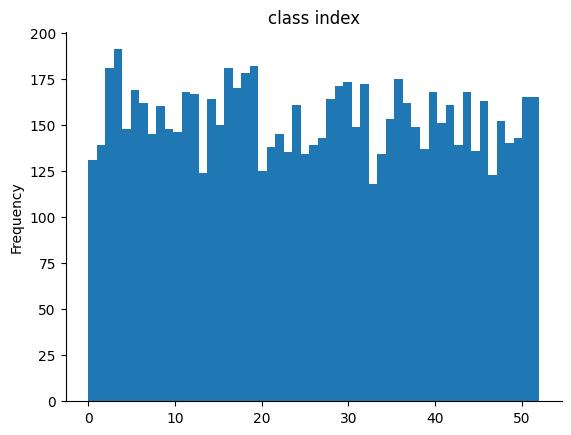

In [10]:
# @title class index

from matplotlib import pyplot as plt
df['class index'].plot(kind='hist', bins=53, title='class index')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
df[df["data set"] == "train"].shape, df[df["data set"] == "valid"].shape, df[df["data set"] == "test"].shape,

((7625, 5), (265, 5), (265, 5))

In [12]:
df["labels"].unique()

array(['ace of clubs', 'ace of diamonds', 'ace of hearts',
       'ace of spades', 'eight of clubs', 'eight of diamonds',
       'eight of hearts', 'eight of spades', 'five of clubs',
       'five of diamonds', 'five of hearts', 'five of spades',
       'four of clubs', 'four of diamonds', 'four of hearts',
       'four of spades', 'jack of clubs', 'jack of diamonds',
       'jack of hearts', 'jack of spades', 'joker', 'king of clubs',
       'king of diamonds', 'king of hearts', 'king of spades',
       'nine of clubs', 'nine of diamonds', 'nine of hearts',
       'nine of spades', 'queen of clubs', 'queen of diamonds',
       'queen of hearts', 'queen of spades', 'seven of clubs',
       'seven of diamonds', 'seven of hearts', 'seven of spades',
       'six of clubs', 'six of diamonds', 'six of hearts',
       'six of spades', 'ten of clubs', 'ten of diamonds',
       'ten of hearts', 'ten of spades', 'three of clubs',
       'three of diamonds', 'three of hearts', 'three of spades',

Metaparameters

In [13]:
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
classifier_dropout=0.45
spatial_dropout=0.25

In [14]:
df['card type'].unique()

array(['ace', 'eight', 'five', 'four', 'jack', 'xxx', 'king', 'nine',
       'queen', 'seven', 'six', 'ten', 'three', 'two'], dtype=object)

In [15]:
transform_test = T.Compose([T.ToImage(),
                       T.ToDtype(torch.float32, scale=True),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Enhanced transform for training data with augmentation
transform_train = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    # Random resized crop to help with scale invariance
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
    # Random horizontal flip
    T.RandomHorizontalFlip(p=0.3),
    # Color jitter for lighting invariance
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Random rotation to help with rotation invariance - good for card recognition
    T.RandomRotation(degrees=15),
    # Occasionally convert to grayscale
    T.RandomGrayscale(p=0.1),
    # Normalize
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [64]:
test_data = datasets.ImageFolder(root="./cards-image-datasetclassification/test", transform=transform_test)
# train_data = datasets.ImageFolder(root="./cards-image-datasetclassification/train", transform=transform_train) # train
train_data = datasets.ImageFolder(root="./cards-image-datasetclassification/train", transform=transform_test) # fine-tuning
valid_data = datasets.ImageFolder(root="./cards-image-datasetclassification/valid", transform=transform_test)

In [65]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [66]:
X, y = next(iter(train_dataloader))

In [67]:
print('Data shapes (train/test):')
print( X.data.shape )

print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([128, 3, 224, 224])

Data value range:
(tensor(-1.), tensor(1.))


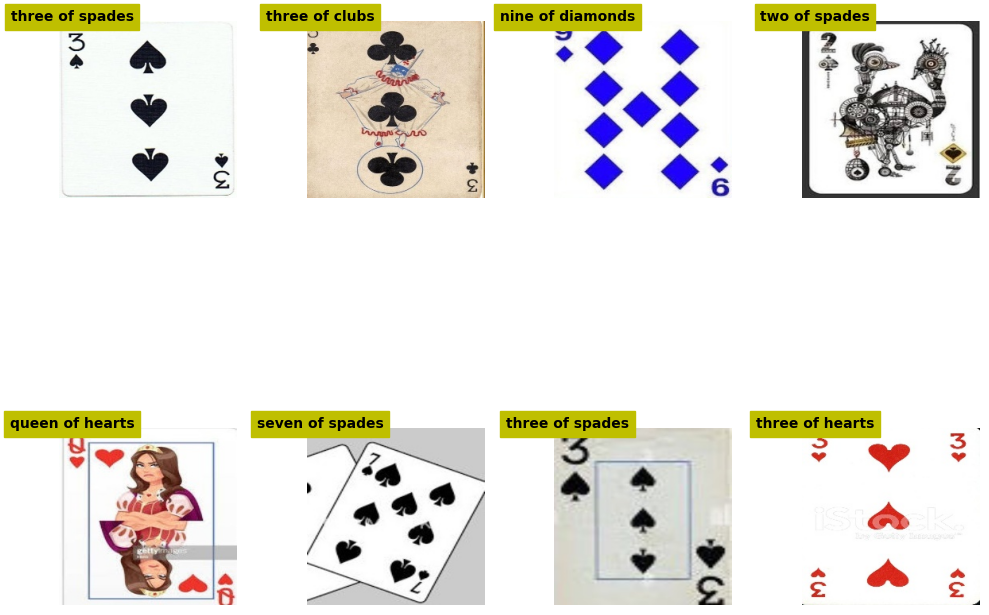

In [68]:
fig,axs = plt.subplots(2, 4,figsize=(10, 10))

for (i,ax) in enumerate(axs.flatten()):
  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train_data.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

Train

In [21]:
def train_step(model, data_loader, loss_fn, optimizer, device, scaler=None):
    model.train()
    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        # Using AMP autocast if scaler is provided
        if scaler is not None:
            with autocast(device_type='cuda' if 'cuda' in str(device) else 'cpu'):
                y_pred = model(X)
                loss = loss_fn(y_pred, y)

            train_loss += loss.item()
            optimizer.zero_grad()

            # Scale gradients and call backward
            scaler.scale(loss).backward()

            # Unscale gradients and step optimizer
            scaler.step(optimizer)

            # Update the scaler for next iteration
            scaler.update()
        else:
            # Original non-AMP training path
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device,
          scheduler=None,
          use_amp=True):  # Add AMP parameter

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "learning_rates": []  # Track learning rates
        }

    model.to(device)

    # Initialize gradient scaler for AMP
    scaler = GradScaler() if use_amp and 'cpu' not in str(device) else None

    # Track the best validation accuracy and corresponding epoch
    best_acc = 0.0
    best_epoch = 0

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            scaler=scaler  # Pass scaler to train_step
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        results["learning_rates"].append(current_lr)

        # Step the scheduler if it exists (using validation loss)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
            else:
                scheduler.step()

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Save the best model based on validation accuracy
        if test_acc > best_acc and (epoch + 1) % 5 == 0:
            best_acc = test_acc
            best_epoch = epoch
            torch.save(model.state_dict(), f'best_model.pth')
            print(f"Best model saved at epoch {epoch+1} with accuracy: {best_acc:.4f}")

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"lr: {current_lr:.6f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    print(f"\nTraining completed! Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1}")
    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def plot_results(results):
    """Plot training metrics including learning rate."""
    plt.figure(figsize=(15, 10))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["test_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(results["train_acc"], label="Train Accuracy")
    plt.plot(results["test_acc"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(results["learning_rates"])
    plt.title("Learning Rate")
    plt.xlabel("Epochs")
    plt.yscale("log")  # Log scale for better visualization

    plt.tight_layout()
    plt.show()

Model

In [31]:
class BottleneckBlock(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels, stride):
    super().__init__()
    self.use_skip = in_channels == out_channels and stride == 1
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride

    self.block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),

            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride,
                      padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),

            nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    self.shortcut = nn.Identity()
    if not self.use_skip:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )


  def forward(self, x):
    return F.gelu(self.block(x) + self.shortcut(x))

In [33]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
      super().__init__()
      self.pool = nn.AdaptiveAvgPool2d(1)
      self.fc = nn.Sequential(
          nn.Linear(channels, channels // reduction, bias=False),
          nn.GELU(),
          nn.Linear(channels // reduction, channels, bias=False),
          nn.Sigmoid()
      )

    def forward(self, x):
      b, c, _, _ = x.size()
      w = self.pool(x).view(b, c)
      w = self.fc(w).view(b, c, 1, 1)
      return x * w

In [34]:
class CNN(nn.Module):
  def __init__(self, input_size, output_size, spatial_dropout, classifier_dropout):
      super().__init__()
      self.input_size = input_size
      self.output_size = output_size
      self.spatial_dropout = nn.Dropout(spatial_dropout)
      self.classifier_dropout = nn.Dropout(classifier_dropout)
      self.start = nn.Sequential(
          nn.Conv2d(input_size, 64, kernel_size=3, stride=2, padding=1, bias=False),
          nn.BatchNorm2d(64),
          nn.GELU())

      def make_stage(in_c, mid_c, out_c, stride, num_blocks):
        layers = [BottleneckBlock(in_c, mid_c, out_c, stride=stride), SEBlock(out_c)]
        for _ in range(1, num_blocks):
            layers.append(BottleneckBlock(out_c, mid_c, out_c, stride=1))
            layers.append(SEBlock(out_c))
        return nn.Sequential(*layers)

      self.stage1 = make_stage(64, 64, 128, stride=1, num_blocks=2)
      self.stage2 = make_stage(128, 128, 256, stride=2, num_blocks=2)
      self.stage3 = make_stage(256, 256, 512, stride=2, num_blocks=3)
      self.stage4 = make_stage(512, 256, 1024, stride=2, num_blocks=3)
      self.stage5 = make_stage(1024, 512, 1024, stride=2, num_blocks=2)

      self.pool = nn.AdaptiveAvgPool2d(1)
      self.fc = nn.Linear(1024, output_size)

  def forward(self, x):
    x = self.start(x)
    x = self.stage1(x)
    x = self.stage2(x)
    x = self.stage3(x)
    x = self.stage4(x)
    x = self.spatial_dropout(x)
    x = self.stage5(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.classifier_dropout(x)
    x = self.fc(x)
    return x

In [35]:
classes_count = len(train_data.classes)
classes_count

53

In [36]:
model = CNN(3, 53, spatial_dropout, classifier_dropout)

In [37]:
summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              GELU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]           4,096
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              GELU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]             576
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              GELU-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]           8,192
      BatchNorm2d-11        [-1, 128, 112, 112]             256
           Conv2d-12        [-1, 128, 112, 112]           8,192
      BatchNorm2d-13        [-1, 128, 112, 112]             256
  BottleneckBlock-14        [-1, 128, 1

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Add learning rate scheduler
# ReduceLROnPlateau reduces learning rate when a metric has stopped improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',              # Monitor loss for improvement
    factor=0.1,              # Reduce LR by a factor of 10 when triggered
    patience=5,              # Number of epochs with no improvement after which LR will be reduced
    min_lr=1e-6              # Lower bound on the learning rate
)

load model

In [50]:
files.upload()
model.load_state_dict(torch.load("cards_classification_model.pth"))

Saving cards_classification_model.pth to cards_classification_model (2).pth


<All keys matched successfully>

train

In [ ]:
results = train(
    model=model,
    train_data_loader=train_dataloader,
    test_data_loader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
    scheduler=scheduler,  # Pass the scheduler to the train function
    use_amp=True  # Enable AMP
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0222 | train_acc: 99.3258 | test_loss: 0.0980 | test_acc: 98.4375 | lr: 0.001000 | time: 67.0556
Epoch: 2 | train_loss: 0.0316 | train_acc: 99.0755 | test_loss: 0.0860 | test_acc: 98.4375 | lr: 0.001000 | time: 66.8445
Epoch: 3 | train_loss: 0.0206 | train_acc: 99.3388 | test_loss: 0.0850 | test_acc: 98.1771 | lr: 0.001000 | time: 66.7371
Epoch: 4 | train_loss: 0.0382 | train_acc: 98.9120 | test_loss: 0.1357 | test_acc: 97.6562 | lr: 0.001000 | time: 67.0209
Best model saved at epoch 5 with accuracy: 97.9167
Epoch: 5 | train_loss: 0.0431 | train_acc: 98.7109 | test_loss: 0.0998 | test_acc: 97.9167 | lr: 0.001000 | time: 67.1285
Epoch: 6 | train_loss: 0.0181 | train_acc: 99.5081 | test_loss: 0.0424 | test_acc: 98.9583 | lr: 0.000100 | time: 66.8096
Epoch: 7 | train_loss: 0.0079 | train_acc: 99.8307 | test_loss: 0.0382 | test_acc: 98.9583 | lr: 0.000100 | time: 66.7173
Epoch: 8 | train_loss: 0.0064 | train_acc: 99.8698 | test_loss: 0.0389 | test_acc: 98.9583 | lr

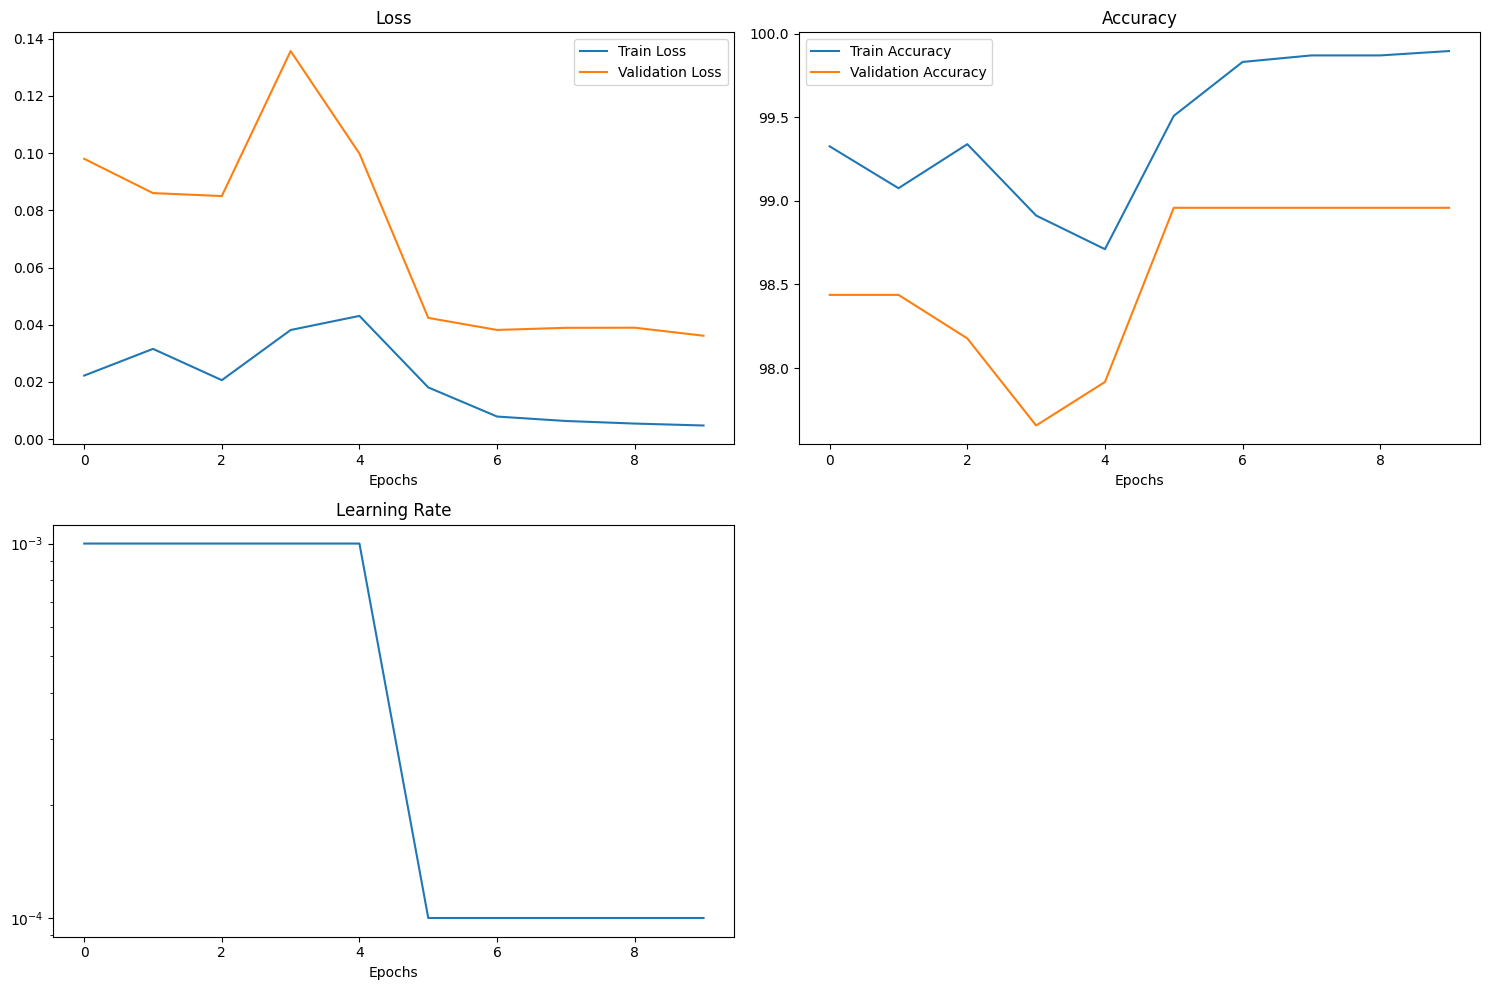

In [ ]:
plot_results(results)

save results

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'cards_classification_model.pth')

# Save the training results
import json
with open('training_results.json', 'w') as f:
    json.dump(results, f)

# Download the model and results files
files.download('cards_classification_model.pth')
files.download('training_results.json')

test with my own photos

In [ ]:
!rm -r photoy_folder

In [56]:
files.upload()
!unzip photo_redacted_resized_224 -d photo_folder

Archive:  photo_redacted_resized_224.zip
   creating: photo_folder/photo_redacted_resized_224/
  inflating: photo_folder/photo_redacted_resized_224/1.jpg  
  inflating: photo_folder/photo_redacted_resized_224/10.jpg  
  inflating: photo_folder/photo_redacted_resized_224/2.jpg  
  inflating: photo_folder/photo_redacted_resized_224/3.jpg  
  inflating: photo_folder/photo_redacted_resized_224/4.jpg  
  inflating: photo_folder/photo_redacted_resized_224/5.jpg  
  inflating: photo_folder/photo_redacted_resized_224/6.jpg  
  inflating: photo_folder/photo_redacted_resized_224/7.jpg  
  inflating: photo_folder/photo_redacted_resized_224/8.jpg  
  inflating: photo_folder/photo_redacted_resized_224/9.jpg  


In [57]:
# Define the path to your photo folder
photo_folder = "/content/photo_folder/photo_redacted_resized_224"  # Replace with your actual folder path

# Create the folder if it doesn't exist
if not os.path.exists(photo_folder):
    os.makedirs(photo_folder)
    print(f"Created folder: {photo_folder}")


# Define image transformations (adjust to your model's requirements)
transform_test = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the model (replace 'your_model.pth' with your model's file)
model.load_state_dict(torch.load('cards_classification_model.pth'))
model.to(device)
model.eval()

# Iterate through the images in the folder
for filename in os.listdir(photo_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Adjust extensions if necessary
        img_path = os.path.join(photo_folder, filename)

        try:
            # Open and transform the image
            img = Image.open(img_path)
            img_tensor = transform_test(img).unsqueeze(0).to(device)

            # Make a prediction
            with torch.no_grad():
                prediction = model(img_tensor)
                predicted_class = torch.argmax(prediction, dim=1).item()

            # Print or store the result
            print(f"Image: {filename}, Predicted Class: {train_data.classes[predicted_class]}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")


Image: 6.jpg, Predicted Class: two of clubs
Image: 10.jpg, Predicted Class: ten of hearts
Image: 4.jpg, Predicted Class: queen of clubs
Image: 9.jpg, Predicted Class: seven of diamonds
Image: 2.jpg, Predicted Class: king of clubs
Image: 3.jpg, Predicted Class: nine of spades
Image: 8.jpg, Predicted Class: jack of clubs
Image: 7.jpg, Predicted Class: two of spades
Image: 1.jpg, Predicted Class: six of clubs
Image: 5.jpg, Predicted Class: ace of hearts


not redacted photos: accurancy 2/10

redacted photos: accurancy 10/10



Visualizing incorrect predictions

Number of incorrect predictions: 6


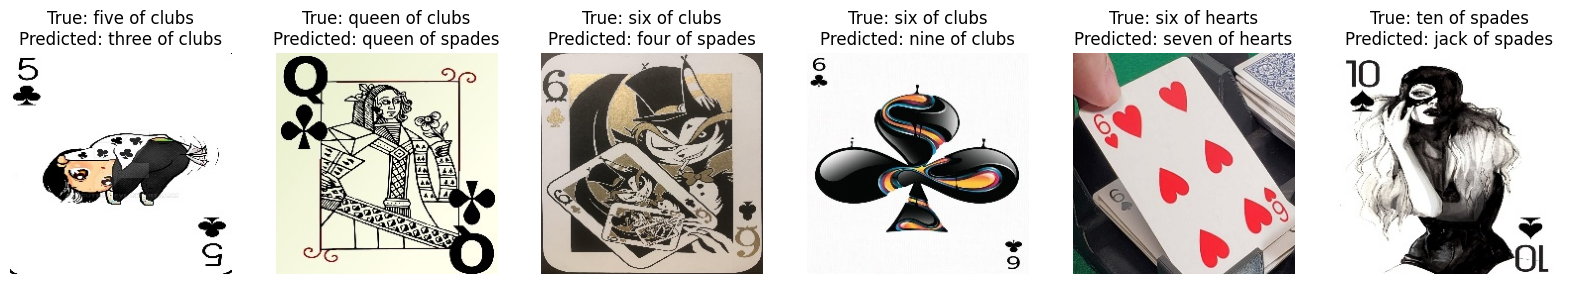

In [71]:
def test_model_with_visualization(model, test_dataloader, loss_fn, device):
    model.eval()
    incorrect_predictions = []

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            predicted_labels = y_pred.argmax(dim=1)

            for i in range(len(X)):
                if predicted_labels[i] != y[i]:
                    incorrect_predictions.append((X[i], y[i], predicted_labels[i]))

    # Visualize incorrect predictions
    num_images_to_show = min(len(incorrect_predictions), 10) # Show up to 10 images
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 5))

    print("Number of incorrect predictions:", len(incorrect_predictions))

    for i in range(num_images_to_show):
      image, true_label, predicted_label = incorrect_predictions[i]
      image = image.cpu().numpy().transpose((1, 2, 0))
      image = image/2 + .5 # undo normalization

      axes[i].imshow(image)
      axes[i].set_title(f"True: {train_data.classes[true_label.item()]}\nPredicted: {train_data.classes[predicted_label.item()]}")
      axes[i].axis('off')
    plt.show()

# Example usage
test_model_with_visualization(model, test_dataloader, loss_fn, device)


In [72]:
def test_model(model, test_dataloader, loss_fn, device):
    """Tests the given model using the provided test dataloader.

    Args:
        model: The PyTorch model to test.
        test_dataloader: The DataLoader for the test dataset.
        loss_fn: The loss function to use for evaluation.
        device: The device (CPU or GPU) to run the evaluation on.

    Returns:
        A tuple containing the average test loss and the test accuracy.
    """

    model.eval()  # Set the model to evaluation mode
    test_loss, test_acc = 0, 0

    with torch.no_grad():  # Disable gradient calculations during testing
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # Make predictions
            y_pred = model(X)

            # Calculate the loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(test_dataloader), test_acc / len(test_dataloader)

# Example usage:
test_loss, test_accuracy = test_model(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1034
Test Accuracy: 98.4375
